In [399]:
import os
import sys

import random
import numpy as np
import scipy as sp
import pandas as pd

from collections import Counter, defaultdict

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

In [400]:
def compute_matrices(m1, m2, num_reports):
    print(m1.shape)
    print(m2.shape)
    A = (m1.T @ m2)
    B = (m1.sum(0).reshape((m1.shape[1],1)) - A)
    B[B==0] = 1
    C = (m2.sum(0) - A)
    C[C==0] = 1
    D = (num_reports-(A+B+C))
    
    PRR = ((A/B)/(C/D))
    Tc = A/(A+B+C)

    return {
        'A': A,
        'B': B,
        'C': C,
        'D': D,
        'PRR': PRR,
        'Tc': Tc
    }

def build_dataframe(matrices, ordered_m1, m1_name, ordered_m2, m2_name, m12label=None, m22label=None, minA=10):
    
    mask = matrices['A']>=minA
    indices = np.where(mask)
    dfdata = {}

    dfdata[m1_name] = [ordered_m1[i] for i in indices[0]]
    if m12label is not None:
        dfdata[f"{m1_name}_label"] = [m12label.get(ordered_m1[i], i) for i in indices[0]]
    
    dfdata[m2_name] = [ordered_m2[i] for i in indices[1]]
    if m22label is not None:
        dfdata[f"{m2_name}_label"] = [m22label.get(ordered_m2[i], i) for i in indices[1]]

    for key, mat in matrices.items():
        dfdata[key] = mat[mask]

    return pd.DataFrame(dfdata)

In [403]:
ndrugs = 25

drugs = list()
for drug in range(ndrugs):
    for _ in range(random.randint(1, 10)):
        drugs.append(f"D{drug}")

drug_probs = pd.Series(drugs).value_counts(normalize=True)
# drug_probs

In [404]:
nreactions = 50

reactions = list()
for reaction in range(nreactions):
    for _ in range(random.randint(2,10)):
        reactions.append(f"Rxn{reaction}")

rxn_probs = pd.Series(reactions).value_counts(normalize=True)
# rxn_probs

In [405]:
nindications = 30
indications = list()
for indication in range(nindications):
    for _ in range(random.randint(1, 10)):
        indications.append(f"I{indication}")

ind_probs = pd.Series(indications).value_counts(normalize=True)

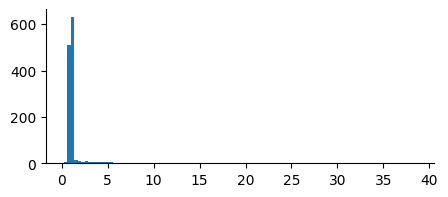

In [406]:
drug_rxn_factors = dict()
drug_rxn_truth = dict()

proportion_true = 0.10

for drug in drug_probs.index:
    for rxn in rxn_probs.index:
        if np.random.rand() <= proportion_true:
            # true drug->reactions relationships
            factor = np.exp(np.random.normal(1, 1))
            drug_rxn_truth[(drug,rxn)] = 1.0
        else:
            # not true relatinoship 
            factor = np.exp(np.random.normal(0, 0.1))
            drug_rxn_truth[(drug,rxn)] = 0.0
        drug_rxn_factors[(drug,rxn)] = factor

drf = list()
for drug in drug_probs.index:
    drf.append([drug_rxn_factors[(drug, rxn)] for rxn in rxn_probs.index])

plt.figure(figsize=(5,2))
# plt.hist(np.log(list(drug_rxn_factors.values())), bins=100)
plt.hist(drug_rxn_factors.values(), bins=100)
sns.despine()

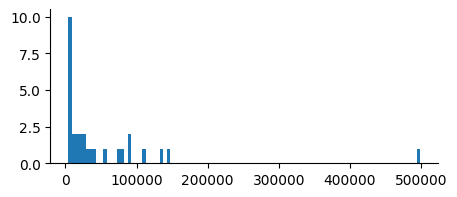

In [457]:
ind_rxn_factors = dict()

for ind in ind_probs.index:
    # randomly select one reaction that this indication will cause
    rxnid = np.random.choice(len(rxn_probs), 1, True)[0]
    rxn = rxn_probs.index[rxnid]
    # indications cause big reactions
    factor = np.exp(np.random.normal(10, 1))
    ind_rxn_factors[(ind,rxn)] = factor

irf = list()
for ind in ind_probs.index:
    irf.append([ind_rxn_factors.get((ind, rxn), 1.0) for rxn in rxn_probs.index])

plt.figure(figsize=(5,2))
# plt.hist(np.log(list(drug_rxn_factors.values())), bins=100)
plt.hist(ind_rxn_factors.values(), bins=100)
sns.despine()

In [458]:
# establish correlations between drugs and indications
drug_indid_probs = defaultdict(dict)
for drug in drug_probs.index:
    num_inds = max(1, np.random.poisson(lam=2))
    random_inds = np.random.choice(len(ind_probs), num_inds, False)
    inds = list()
    for ind in random_inds:
        for _ in range(random.randint(2,10)):
            inds.append(ind)
    
    diprobs = pd.Series(inds).value_counts(normalize=True)
    for ind, prob in diprobs.items():
        drug_indid_probs[drug][ind] = prob

# plt.hist(drug_ind_probs.values());
# drug_indid_probs

In [489]:
nreports = 10000

# reports by drugs
drugs = np.zeros(shape=(nreports, len(drug_probs)))
# reports by reactions
rxns = np.zeros(shape=(nreports, len(rxn_probs)))
# reports by indications
inds = np.zeros(shape=(nreports, len(ind_probs)))

for rid in range(nreports):
    drugid = np.random.choice(len(drug_probs), 1, True, p=drug_probs)[0]
    adjusted_probs = drf[drugid]*rxn_probs
    adjusted_probs /= (adjusted_probs).sum()
    rxnid = np.random.choice(len(rxn_probs), 1, True, p=adjusted_probs)[0]
    
    # print(rid, drug_probs.index[drugid], rxn_probs.index[rxnid])

    drugs[rid, drugid] = 1
    rxns[rid, rxnid] = 1

    # check to see if the drug's indications add any reactions to this report
    indids, probs = zip(*drug_indid_probs[drug_probs.index[drugid]].items())
    indid = np.random.choice(indids, 1, True, p=probs)[0]
    ind = ind_probs.index[indid][0]

    adjusted_probs = irf[indid]*rxn_probs
    adjusted_probs /= (adjusted_probs).sum()
    rxnid = np.random.choice(len(rxn_probs), 1, True, p=adjusted_probs)[0]

    inds[rid, indid] = 1
    # rxns[rid, rxnid] = 1
# drugs, rxns

In [490]:
# A = (drugs.T @ rxns)
# print(A.shape, drugs.sum(0).reshape((10,1)).shape)
# B = (drugs.sum(0).reshape((drugs.shape[1],1))-A)
# drugs.shape, rxns.shape, drugs.sum(0).shape

In [491]:
matrices = compute_matrices(drugs, rxns, num_reports=nreports)
drug_rxn = build_dataframe(matrices, drug_probs.index, 'drug', rxn_probs.index, 'reaction', minA=1)
drug_rxn['factor'] = [drug_rxn_factors[(d,r)] for _, (d, r) in drug_rxn[['drug', 'reaction']].iterrows()]
drug_rxn['truth'] = [drug_rxn_truth[(d, r)] for _, (d, r) in drug_rxn[['drug', 'reaction']].iterrows()]
drug_rxn.sort_values(by='PRR', ascending=False).head(5)

(10000, 25)
(10000, 50)


,drug,reaction,A,B,C,D,PRR,Tc,factor,truth
608,D14,Rxn4,163.0,233.0,246.0,9358.0,26.612129,0.253894,38.553190,1.0
1048,D10,Rxn24,24.0,50.0,259.0,9667.0,17.915676,0.072072,12.056684,1.0
1009,D11,Rxn16,13.0,139.0,60.0,9788.0,15.257074,0.061321,20.919458,1.0
448,D1,Rxn44,137.0,373.0,253.0,9237.0,13.409796,0.179554,12.672189,1.0
540,D0,Rxn45,52.0,451.0,101.0,9396.0,10.726263,0.086093,16.320028,1.0


In [492]:
matrices = compute_matrices(inds, rxns, num_reports=nreports)
ind_rxn = build_dataframe(matrices, ind_probs.index, 'indication', rxn_probs.index, 'reaction', minA=1)
ind_rxn.sort_values(by='PRR', ascending=False).head()

(10000, 30)
(10000, 50)


,indication,reaction,A,B,C,D,PRR,Tc
931,I27,Rxn22,48.0,155.0,258.0,9539.0,11.449662,0.104121
261,I12,Rxn16,4.0,52.0,69.0,9875.0,11.008919,0.032000
586,I16,Rxn16,9.0,134.0,64.0,9793.0,10.277169,0.043478
826,I4,Rxn44,142.0,650.0,248.0,8960.0,7.892804,0.136538
976,I21,Rxn43,7.0,30.0,304.0,9659.0,7.413706,0.020528


In [493]:
matrices = compute_matrices(inds, drugs, num_reports=nreports)
ind_ing = build_dataframe(matrices, ind_probs.index, 'indication', drug_probs.index, 'drug', minA=1)
ind_ing.sort_values(by='PRR', ascending=False).head()

(10000, 30)
(10000, 25)


,indication,drug,A,B,C,D,PRR,Tc
18,I0,D2,657.0,1.0,1.0,9341.0,6.137037e+06,0.996965
11,I17,D24,87.0,17.0,1.0,9895.0,5.063912e+04,0.828571
42,I4,D1,510.0,282.0,1.0,9207.0,1.665096e+04,0.643127
36,I18,D21,220.0,1.0,216.0,9563.0,9.740093e+03,0.503432
48,I27,D3,203.0,1.0,200.0,9596.0,9.739940e+03,0.502475


In [494]:
# matrices = compute_matrices(drugs, drugs, num_reports=nreports)

# ing_ing = build_dataframe(matrices,
#                           drug_probs.index, 'ingredient1',
#                           drug_probs.index, 'ingredient2',
#                           minA=1)

# ing_ing = ing_ing[ing_ing['ingredient1'] != ing_ing['ingredient2']]
# ing_ing.sort_values(by='Tc', ascending=False).head(10)

Ind PRRs greatrer than 10: 5
(5, 6)


SignificanceResult(statistic=0.6668859288553501, pvalue=0.21889398131323165)

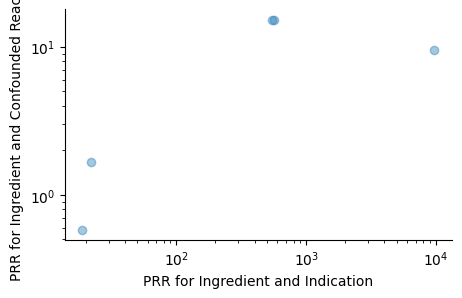

In [495]:
# build datafraem to look at confounding by indication
ind_keep = ['drug', 
        'reaction', 
        'indication',
        'PRR_ing_rxn',
        'PRR_ind_ing',
        'PRR_ind_rxn']
ind_merged = drug_rxn.merge(ind_ing, 
                            on='drug',
                            suffixes=('_ing_rxn', '_ind_ing')
                          ).merge(ind_rxn,
                            on=('indication', 'reaction',),
                            suffixes=('', '_ind_rxn'))

ind_merged.rename(columns={'PRR': 'PRR_ind_rxn'}, inplace=True)
ind_reduced = ind_merged[ind_keep]
# reduced[reduced['reaction']=='35506628'].head()

# plt.figure(figsize=(5,3))
# plt.hist(ind_reduced[ind_reduced['PRR_ind_rxn']>1]['PRR_ind_rxn'], bins=100)

print(f"Ind PRRs greatrer than 10: {(ind_reduced['PRR_ind_rxn'] > 10).sum()}")

# we only care about whent the relationship between the indication and the reaction is high
ind_rxn_high = ind_reduced[ind_reduced['PRR_ind_rxn'] > 10]
print(ind_rxn_high.shape)

plt.figure(figsize=(5,3))
plt.scatter(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'], alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('PRR for Ingredient and Indication')
plt.ylabel('PRR for Ingredient and Confounded Reaction')
sns.despine()

sp.stats.spearmanr(ind_rxn_high['PRR_ind_ing'], ind_rxn_high['PRR_ing_rxn'])

Tc: SignificanceResult(statistic=0.27312010515532575, pvalue=4.90501900639575e-21)
PRR: SignificanceResult(statistic=0.32613946657576676, pvalue=8.785841871861823e-30)
Tc AUROC: 0.768 AUPR: 0.638
PRR AUROC: 0.810 AUPR: 0.643


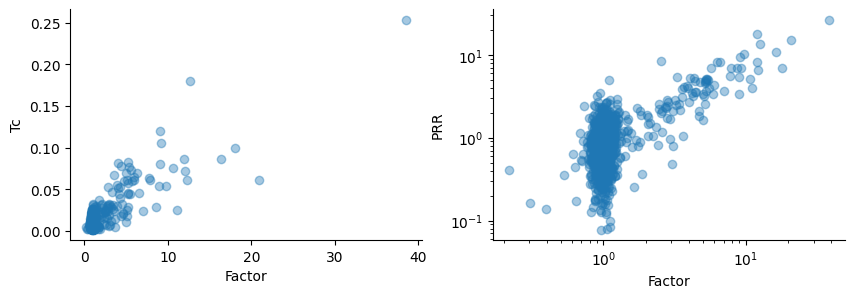

In [496]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.scatter(drug_rxn['factor'], drug_rxn['Tc'], alpha=0.4)
plt.xlabel('Factor')
# plt.xscale('log')
plt.ylabel('Tc')
sns.despine()
plt.subplot(1,2,2)
plt.scatter(drug_rxn['factor'], drug_rxn['PRR'], alpha=0.4)
plt.xlabel('Factor')
plt.xscale('log')
plt.ylabel('PRR')
plt.yscale('log')
sns.despine()

print(f"Tc: {sp.stats.spearmanr(drug_rxn['factor'], drug_rxn['Tc'])}")
print(f"PRR: {sp.stats.spearmanr(drug_rxn['factor'], drug_rxn['PRR'])}")
print(f"Tc AUROC: {sklearn.metrics.roc_auc_score(drug_rxn['truth'], drug_rxn['Tc']):.3f} AUPR: {sklearn.metrics.average_precision_score(drug_rxn['truth'], drug_rxn['Tc']):.3f}")
print(f"PRR AUROC: {sklearn.metrics.roc_auc_score(drug_rxn['truth'], drug_rxn['PRR']):.3f} AUPR: {sklearn.metrics.average_precision_score(drug_rxn['truth'], drug_rxn['PRR']):.3f}")